### ARMA-GARCH modelling (plots)
- visual example showing the differences between ARMA and ARMA-GARCH 
- for more complete example (which includes formal tests etc) see the main seminar materials.
- american airlines dataset

In [15]:
# load the data
rm(list = ls())
library(tseries)
library(forecast)
library(repr)
library(rugarch) # package for GARCH modelling
library(moments) # package for kurtosis estimation
library(aTSA) # package for ARCH-LM test
library(rmgarch) # multivariate garch modelling
library(FinTS)
library(quantmod) # download data
options(repr.plot.width = 8, repr.plot.height = 4) # set the plotting parameters
load('AAL_dataset.R')
price = data[,'AAL.Adjusted']
log_ret <- diff(log(price)) 
length(log_ret)
log_ret = na.omit(log_ret)
length(log_ret)

[1] 2767

[1] 2766

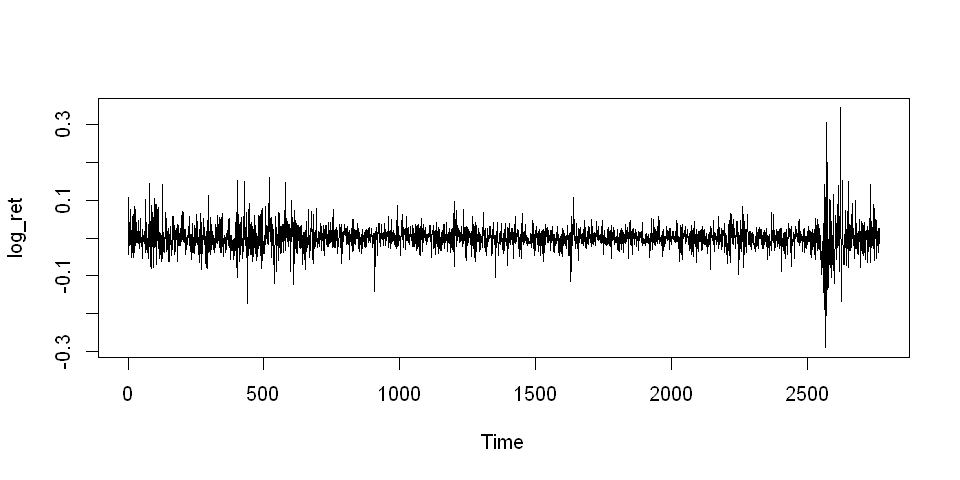

In [2]:
#returns
plot.ts(log_ret)

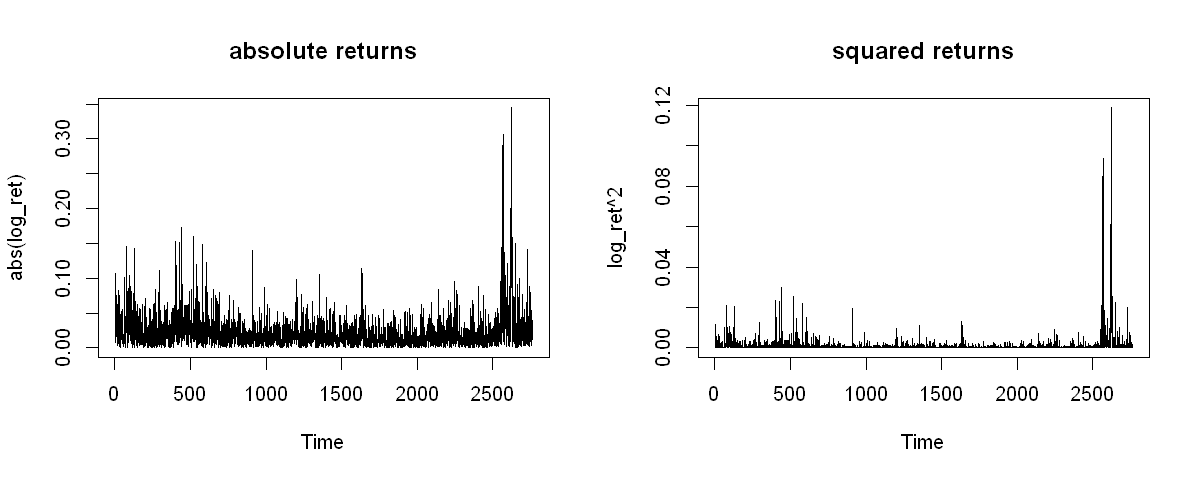

In [3]:
# absolute returns - proxy for volatility
# returns^2 - proxy for variance
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,2))
plot.ts(abs(log_ret), main='absolute returns')
plot.ts(log_ret^2, main='squared returns')

In [4]:
# when we estimate ARMA model (without GARCH), we assume fixed variance
fit = auto.arima(log_ret)
fit
# in case of ARMA(1,0) sigma^2 estimated as 0.001092

Series: log_ret 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.0653
s.e.  0.0190

sigma^2 estimated as 0.001092:  log likelihood=5507.22
AIC=-11010.44   AICc=-11010.44   BIC=-10998.59

In [5]:
# the variance estimated:
fit$sigma2

[1] 0.001092158

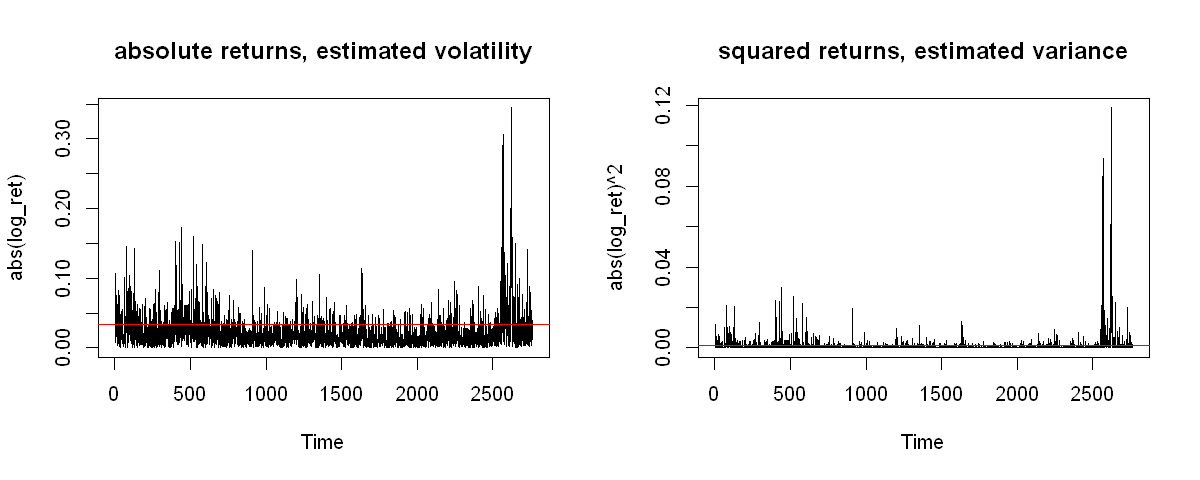

In [6]:
# if we use fixed variance in our model (ARMA model): (first absolute returns vs fixed volatility, second: squared returns vs estimated variance)
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,2))
plot.ts(abs(log_ret), main='absolute returns, estimated volatility')
abline(h=sqrt(fit$sigma2), col = "red")
plot.ts(abs(log_ret)^2, main='squared returns, estimated variance')
abline(h=(fit$sigma2), col = "red")

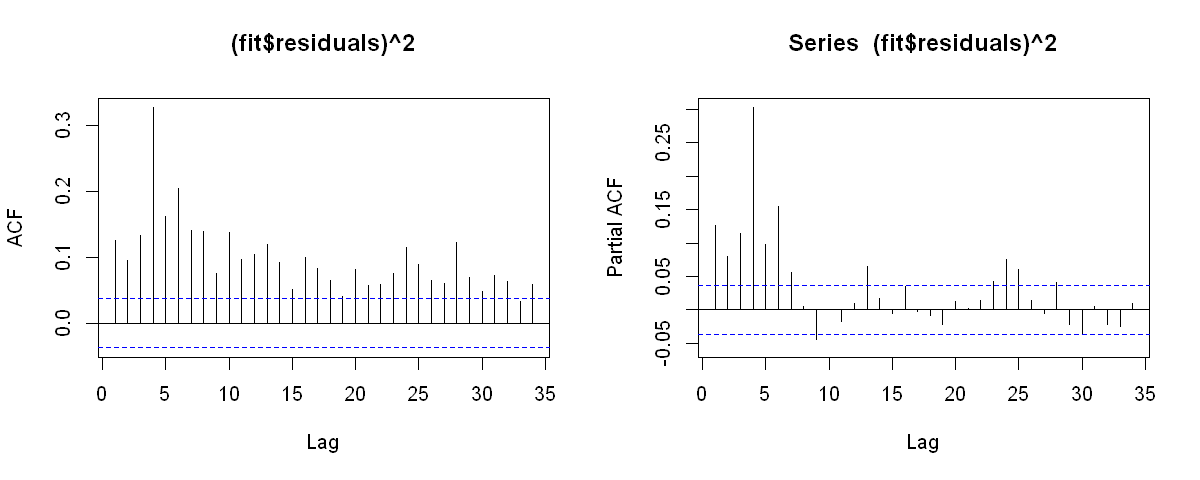

In [7]:
# checking arch effects: ( + we have formal tests)
# squared returns - clustering of volatility
par(mfrow = c(1,2))
Acf((fit$residuals)^2)
Pacf((fit$residuals)^2)

In [8]:
# fit ARMA-GARCH to get time varying estimate of volatility:
# specify the model that we want to estimate
model_specification <- ugarchspec(mean.model = list(armaOrder = c(1, 0), include.mean = TRUE), 
                      variance.model = list(garchOrder = c(1, 1)))

# estimate the model
fit_garch <- ugarchfit(spec = model_specification, data = log_ret)
#fit_garch

In [9]:
# get estimated time-varying volatility:
volatility_est = sigma(fit_garch)
head(volatility_est)

                 [,1]
2010-01-05 0.03305426
2010-01-06 0.04012345
2010-01-07 0.04037440
2010-01-08 0.03980563
2010-01-11 0.03896626
2010-01-12 0.03812766

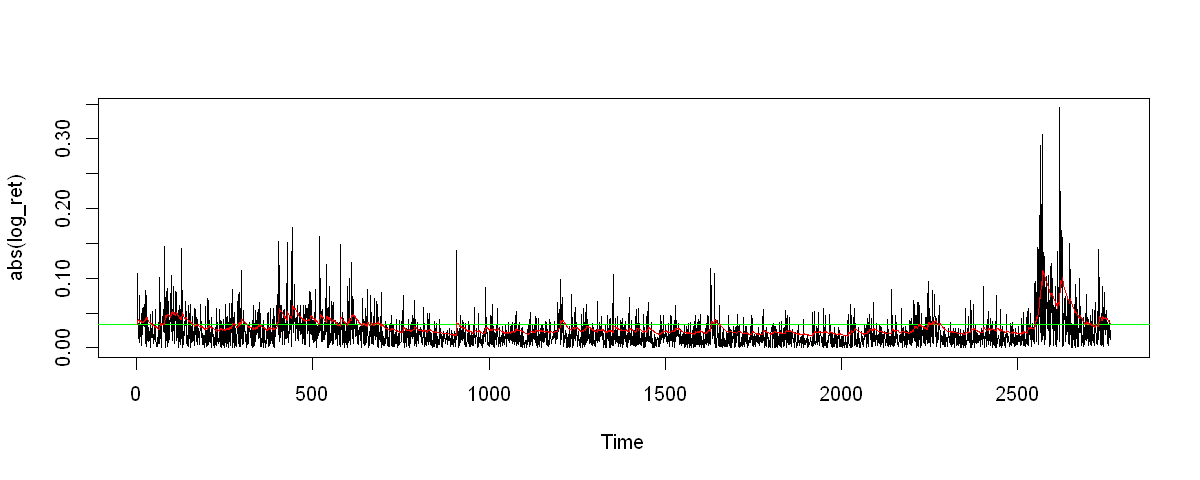

In [10]:
# estimated volatality ARMA vs ARMA-GARCH model"
plot.ts(abs(log_ret)) 
abline(h=sqrt(fit$sigma2), col = "green") # ARMA only
lines(array(volatility_est),col="red") # ARMA-GARCH estimated volatility, estimated sigma

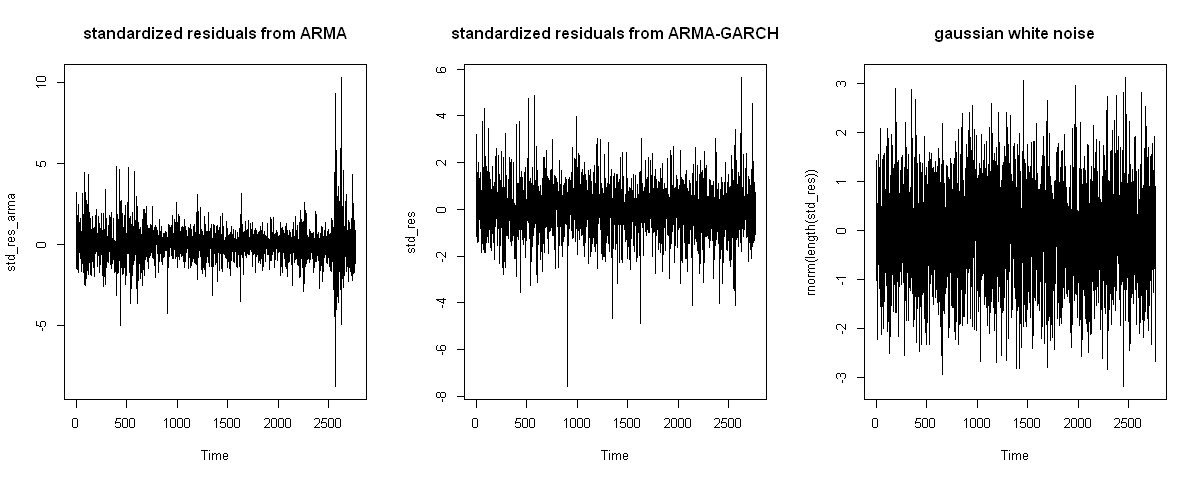

In [11]:
# with our models, we assume that standardized residuals follow standard normal distribution
# comparison of ARMA residuals, ARMA-GARCH residuals and gaussian white noise

# standardized residuals = residuals from the model / square root of the estimated (conditional) variance

#ARMA: 
std_res_arma = fit$residuals/sqrt(fit$sigma2)

# GARCH get standardized residuals:
volatility_est = sigma(fit_garch) #time varying volatility estimated by garch
res = residuals(fit_garch, standardize = FALSE)
std_res = res/(volatility_est)
# GARCHalternatively (same result)
std_res2 = residuals(fit_garch, standardize = TRUE)

# plot standardized residuals from arma-garch model:
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,3))
plot.ts(std_res_arma, main='standardized residuals from ARMA')
plot.ts(std_res, main='standardized residuals from ARMA-GARCH')
plot.ts(rnorm(length(std_res)), main='gaussian white noise') # as a comparison, 

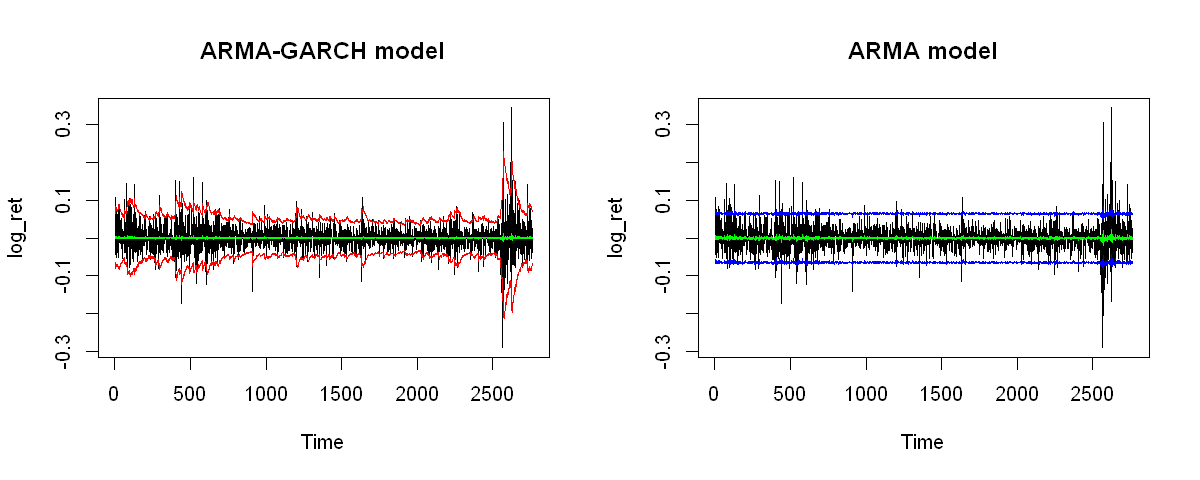

In [12]:
# 95% confidence intervals for fitted values
upper = fitted(fit_garch) + 1.96*volatility_est
lower = fitted(fit_garch) - 1.96*volatility_est


options(repr.plot.width=10, repr.plot.height=4)
par(mfrow = c(1,2))
#GARCH
plot.ts(log_ret, main='ARMA-GARCH model')
lines(array(fitted(fit_garch)), col='green')
lines(array(upper),col="red") 
lines(array(lower),col="red") 

#ARMA:
plot.ts(log_ret, main='ARMA model')
lines(array(fitted(fit)), col='green')
lines(array(fit$fitted + 1.96*sqrt(fit$sigma2)), col = "blue") # ARMA only
lines(array(fit$fitted - 1.96*sqrt(fit$sigma2)), col = "blue") # ARMA only

In [13]:
# comparison of ARMA coefficients and ARMA-GARCH coefficients:
# ar1 lower after we include GARCH (this change before and after volatility modelling is kinda similar concept as omitted variable bias)
fit

Series: log_ret 
ARIMA(1,0,0) with zero mean 

Coefficients:
         ar1
      0.0653
s.e.  0.0190

sigma^2 estimated as 0.001092:  log likelihood=5507.22
AIC=-11010.44   AICc=-11010.44   BIC=-10998.59

In [14]:
fit_garch


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000585    0.000509   1.1491  0.25050
ar1     0.035142    0.020193   1.7403  0.08181
omega   0.000012    0.000002   5.5390  0.00000
alpha1  0.050494    0.001319  38.2760  0.00000
beta1   0.937108    0.005185 180.7409  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000585    0.000565   1.0365 0.299989
ar1     0.035142    0.020255   1.7350 0.082745
omega   0.000012    0.000008   1.5328 0.125325
alpha1  0.050494    0.011514   4.3855 0.000012
beta1   0.937108    0.009604  97.5712 0.000000

LogLikelihood : 5921.135 

Information Criteria
------------------------------------
                